In [1]:
%reset

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential 
from sklearn.preprocessing import RobustScaler
from datetime import date, timedelta, datetime
import math

In [8]:
# Dataset from github repo: https://github.com/sidk003/Stock-Market-Prediction/tree/master/stock_price_prediction/company_stock_prices
aapl_url = 'https://raw.githubusercontent.com/sidk003/Stock-Market-Prediction/master/stock_price_prediction/company_stock_prices/AAPL.csv'
amzn_url = 'https://raw.githubusercontent.com/sidk003/Stock-Market-Prediction/master/stock_price_prediction/company_stock_prices/AMZN.csv'
fb_url = 'https://raw.githubusercontent.com/sidk003/Stock-Market-Prediction/master/stock_price_prediction/company_stock_prices/FB.csv'
msft_url = 'https://raw.githubusercontent.com/sidk003/Stock-Market-Prediction/master/stock_price_prediction/company_stock_prices/MSFT.csv'

In [9]:
# CSV -> pandas dataframe
aapl_closing_price = pd.read_csv(aapl_url)
amzn_closing_price = pd.read_csv(amzn_url)
fb_closing_price = pd.read_csv(fb_url)
msft_closing_price = pd.read_csv(msft_url)

In [11]:
# Importing sentiment dataset
aapl_sentiment_url = 'https://raw.githubusercontent.com/sidk003/Stock-Market-Prediction/master/stock_price_prediction/company_stock_prices/APPL2019News.csv'
aapl_sentiment_df = pd.read_csv(aapl_sentiment_url,  encoding='latin-1')

# Renaming columns
aapl_sentiment_df.rename(columns = {'published':'Date'}, inplace = True)
aapl_sentiment_df.rename(columns = {'sentiment':'Sentiment'}, inplace = True)

In [12]:
# function to get average of sentiment on each day
def get_average_df(df):

  # removing unwanted columns
  selected_columns = df[['Date','Sentiment']]
  new_df = selected_columns.copy()

  # Convertinf sting Sentiments to float
  new_df['Sentiment'] = pd.to_numeric(new_df['Sentiment'],errors='coerce')

  # removing blank sentiment values
  new_df['Date'] = pd.to_datetime(new_df['Date'], format="%Y-%m-%dT%H:%M:%SZ", errors='coerce')
  new_df.dropna()

  # calculating average by mean()
  new_df = new_df.groupby(new_df.Date.dt.date).mean().reset_index()
  
  return new_df

In [13]:
# Run only once 
aapl_sentiment_df = get_average_df(aapl_sentiment_df)
aapl_sentiment_df.head()

,Date,Sentiment
0,2018-12-31,0.133333
1,2019-01-01,0.095000
2,2019-01-02,-0.210000
3,2019-01-03,-0.147273
4,2019-01-04,-0.254167


In [14]:
# function to drop unwanted columns in closing price df
def get_closing_df(df):
  selected_columns = df[['Date','Close']]
  new_df = selected_columns.copy()
  return new_df

In [15]:
aapl_closing_price = get_closing_df(aapl_closing_price)

In [16]:
# converting both df to same datetime format
def combine_df(df1,df2):
  df1.Date = pd.to_datetime(df1.Date)
  df2.Date = pd.to_datetime(df2.Date)
  df = pd.merge(df1, df2, on='Date')
  return df

In [17]:
df = combine_df(aapl_closing_price, aapl_sentiment_df)

In [18]:
df.head()

,Date,Close,Sentiment
0,2018-12-31,39.435001,0.133333
1,2019-01-02,39.480000,-0.210000
2,2019-01-03,35.547501,-0.147273
3,2019-01-04,37.064999,-0.254167
4,2019-01-07,36.982498,-0.346667


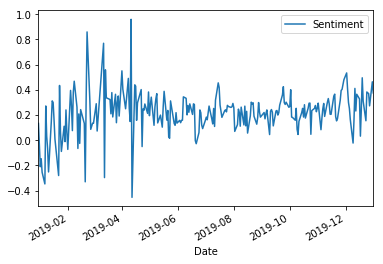

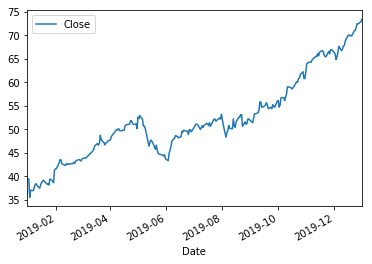

In [19]:
df.plot(x ='Date', y='Sentiment', kind = 'line')
df.plot(x ='Date', y='Close', kind = 'line')
plt.show()

In [20]:
# Preprocessing

# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# saving a copy of date index before changing dates to nos.
date_index = train_df.Date

# # Adding Month and Year in separate columns
d = pd.to_datetime(train_df.Date)
train_df['Month'] = d.dt.strftime('%m')
train_df['Year'] = d.dt.strftime("%Y") 

# # Resetting the index, to convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
train_df.head()

,Date,Close,Sentiment,Month,Year
0,2018-12-31,39.435001,0.133333,12,2018
1,2019-01-02,39.480000,-0.210000,01,2019
2,2019-01-03,35.547501,-0.147273,01,2019
3,2019-01-04,37.064999,-0.254167,01,2019
4,2019-01-07,36.982498,-0.346667,01,2019


In [21]:
# List of considered Features
FEATURES = ['Close', 'Sentiment', 'Month']
print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

data_filtered.head()

FEATURE LIST
['Close', 'Sentiment', 'Month']


,Close,Sentiment,Month
0,39.435001,0.133333,12
1,39.480000,-0.210000,01
2,35.547501,-0.147273,01
3,37.064999,-0.254167,01
4,36.982498,-0.346667,01


In [22]:
# Calculate the number of rows in the data
nrows = data_filtered.shape[0]
np_data_unscaled = np.array(data_filtered)
np_data_unscaled = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data_unscaled.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = RobustScaler()
np_data = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = RobustScaler()
df_Close = pd.DataFrame(data_filtered['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(246, 3)


In [23]:
#Settings
sequence_length = 100

# Split the training data into x_train and y_train data sets
# Get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data.shape[0] * 0.8) #2616

# Create the training data
train_data = np_data[0:train_data_len, :]
x_train, y_train = [], []
# The RNN needs data with the format of [samples, time steps, features].
for i in range(100, train_data_len):
    x_train.append(train_data[i-sequence_length:i,:]) #contains 100 values 0-100 * column
    y_train.append(train_data[i, 0]) #contains the prediction values for validation
    
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Create the test data
test_data = np_data[train_data_len - sequence_length:, :]

# Split the test data into x_test and y_test
x_test, y_test = [], []
test_data_len = test_data.shape[0]
for i in range(sequence_length, test_data_len):
    x_test.append(test_data[i-sequence_length:i,:]) #contains 100 values 0-100 * columsn
    y_test.append(test_data[i, 0]) #contains the prediction values for validation
# Convert the x_train and y_train to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

# Convert the x_train and y_train to numpy arrays
x_test = np.array(x_test); y_test = np.array(y_test)
    
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(97, 100, 3) (97,)
(49, 100, 3) (49,)


In [24]:
# Model Training
model = Sequential()

# Model with 100 Neurons 
# inputshape = 100 Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=False, 
               input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(Dense(1, activation='relu'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

300 100 3


In [25]:
epochs = 5
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(x_train, y_train, batch_size=16, 
                    epochs=epochs, callbacks=[early_stop])

Epoch 1/5
7/7 [==============================] - 1s 206ms/step - loss: 0.0530
Epoch 2/5
7/7 [==============================] - 1s 157ms/step - loss: 0.0303
Epoch 3/5
7/7 [==============================] - 1s 156ms/step - loss: 0.0261
Epoch 4/5
7/7 [==============================] - 1s 160ms/step - loss: 0.0256
Epoch 5/5
7/7 [==============================] - 1s 159ms/step - loss: 0.0243


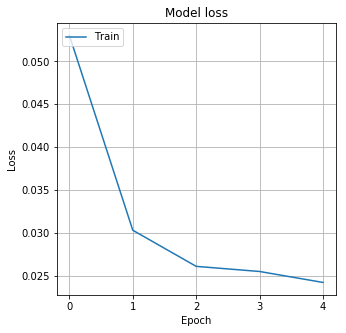

In [26]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(5, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [27]:
# Error Metrics
predictions = model.predict(x_test)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test, predictions)/ y_test))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test, predictions)/ y_test)) ) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

Mean Absolute Percentage Error (MAPE): 28.47 %
Median Absolute Percentage Error (MDAPE): 27.27 %


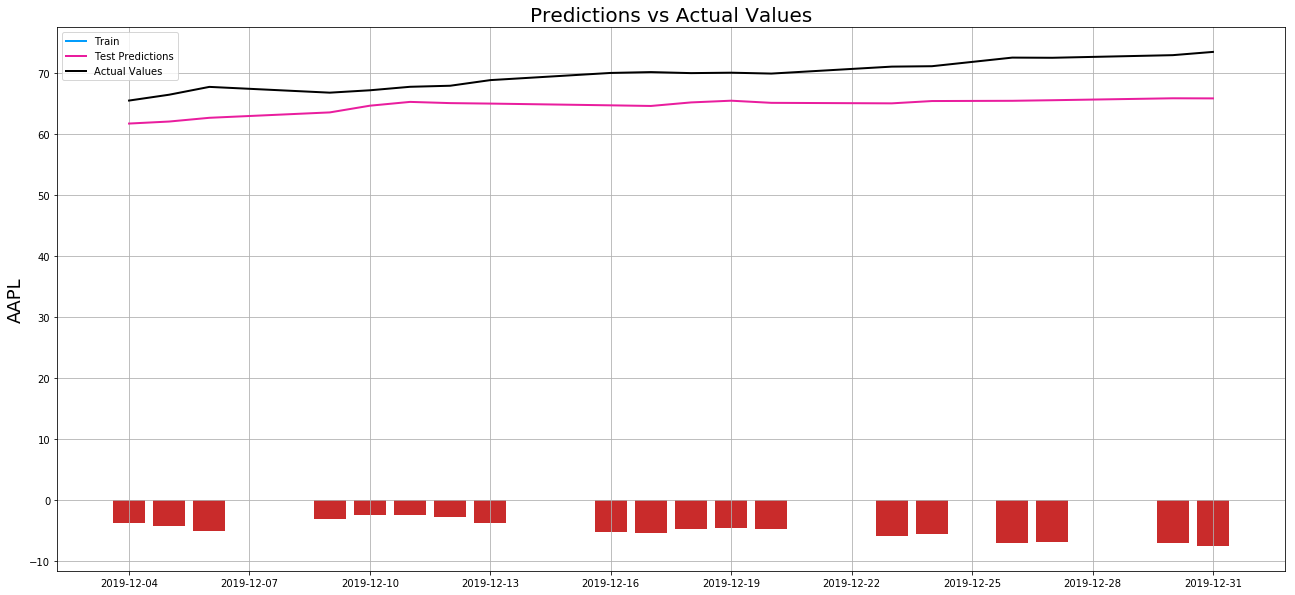

In [30]:
pred_unscaled = scaler_pred.inverse_transform(predictions)

# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=500)

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = date_index

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", pred_unscaled.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)

# Zoom in to a closer timeframe

valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
stockname = 'AAPL'
plt.ylabel(stockname, fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()